# Predicting demand likelihood on Ativo's classified advertisements

> No ramo do comércio eletrônico, a venda de produtos através de anúncios classificados em sites conhece um crescimento rápido. No entanto, é comum que anunciantes, indivíduos ou empresas, se frustram com uma demanda fraca ou inexistente por seus produtos apesar do investimento em propaganda no caso de anunciantes empresariais. Por outro lado, uma demanda alta e persistente por produtos já vendidos causa frustração do anunciante por indicar a venda por um preço a abaixo do preço do mercado. A venda efetiva dos produtos nos sites classificados depende de uma combinação de fatores, que podem fazer uma grande diferença para aumentar o interesse dos consumidores nos produtos.  Exemplos desses fatores incluem descrições, imagens, regiões geográficas, etc. Por exemplo, descrições com nuances ou com poucos detalhes e imagens de pouca qualidade podem reduzir o interesse dos consumidores. 

>A ATIVO, maior site de anúncios classificados na Rússia, está acostumado com a frustração dos seus anunciantes e busca formas de reduzi-la. Com esse objetivo, ela patrocina uma competição iniciada no mês de maio de 2018 através da Kaggle.  A  Kaggle é uma empresa, que possui uma plataforma aberta na qual cientistas, pesquisadores e profissionais do mundo inteiro na área de ciência de dados são desafiados a resolver problemas reais e complexos de empresas por meio de competições. 
A “competição Ativo” da Kaggle desafia pesquisadores a predizer a probabilidade da compra de qualquer produto em função das informações fornecidas no anúncio da plataforma da ATIVO. Essas informações incluem a descrição (título, detalhes, etc.), o contexto (a cidade onde o anúncio foi emitido e anúncios já postados) e o histórico da demanda para anúncios similares no contexto. O dataset que reúne informações de todos os anúncios classificados possui cerca de 7 GB. A competição já conta com mais de 1000 equipes. Com as previsões, a ATIVO espera dar um retorno aos anunciantes sobre como otimizar suas carteiras de produtos, além de fornecer aos anunciantes indicadores sobre o potencial  interesse dos consumidores em seus anúncios.


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
from sklearn import preprocessing, utils
from sklearn.svm import SVC,SVR
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from nltk.corpus import stopwords
from sklearn.naive_bayes import MultinomialNB

In [2]:
dir = 'c:/_dados/_avito/'

In [3]:
df_train = pd.read_csv(dir + 'train.csv')
print(df_train.shape)
df_train.head(2)

(1503424, 18)


,item_id,user_id,region,city,parent_category_name,category_name,param_1,param_2,param_3,title,description,price,item_seq_number,activation_date,user_type,image,image_top_1,deal_probability
0,b912c3c6a6ad,e00f8ff2eaf9,Свердловская область,Екатеринбург,Личные вещи,Товары для детей и игрушки,Постельные принадлежности,NaN,NaN,Кокоби(кокон для сна),"Кокон для сна малыша,пользовались меньше месяц...",400.0,2,2017-03-28,Private,d10c7e016e03247a3bf2d13348fe959fe6f436c1caf64c...,1008.0,0.12789
1,2dac0150717d,39aeb48f0017,Самарская область,Самара,Для дома и дачи,Мебель и интерьер,Другое,NaN,NaN,Стойка для Одежды,"Стойка для одежды, под вешалки. С бутика.",3000.0,19,2017-03-26,Private,79c9392cc51a9c81c6eb91eceb8e552171db39d7142700...,692.0,0.00000


In [4]:
df_test_ = pd.read_csv(dir + 'test.csv')
print(df_test_.shape)
df_test_.head(2)

(508438, 17)


,item_id,user_id,region,city,parent_category_name,category_name,param_1,param_2,param_3,title,description,price,item_seq_number,activation_date,user_type,image,image_top_1
0,6544e41a8817,dbe73ad6e4b5,Волгоградская область,Волгоград,Личные вещи,Детская одежда и обувь,Для мальчиков,Обувь,25,Отдам бесплатно,На ангарском,NaN,66,2017-04-18,Private,a8b57acb5ab304f9c331ac7a074219aed4d349d8aef386...,2020.0
1,65b9484d670f,2e11806abe57,Свердловская область,Нижняя Тура,Хобби и отдых,Велосипеды,Дорожные,NaN,NaN,Продам велосипед,"Продам велосипед KAMA F200,в нормальном состо...",3000.0,4,2017-04-16,Private,NaN,NaN


In [5]:
df_sample_submission=pd.read_csv(dir + 'sample_submission.csv')
print(df_sample_submission.shape)
df_sample_submission.head(2)

(508438, 2)


,item_id,deal_probability
0,6544e41a8817,0.5
1,65b9484d670f,0.5


In [6]:
df_test=pd.concat([df_test_, df_sample_submission], axis=0)
print(df_test.shape)

(1016876, 18)


## Explorando os dados 

Exibindo 5 anúncios. É possivel ver que os dados são em russo.

In [7]:
df_train.head(3)

,item_id,user_id,region,city,parent_category_name,category_name,param_1,param_2,param_3,title,description,price,item_seq_number,activation_date,user_type,image,image_top_1,deal_probability
0,b912c3c6a6ad,e00f8ff2eaf9,Свердловская область,Екатеринбург,Личные вещи,Товары для детей и игрушки,Постельные принадлежности,NaN,NaN,Кокоби(кокон для сна),"Кокон для сна малыша,пользовались меньше месяц...",400.0,2,2017-03-28,Private,d10c7e016e03247a3bf2d13348fe959fe6f436c1caf64c...,1008.0,0.12789
1,2dac0150717d,39aeb48f0017,Самарская область,Самара,Для дома и дачи,Мебель и интерьер,Другое,NaN,NaN,Стойка для Одежды,"Стойка для одежды, под вешалки. С бутика.",3000.0,19,2017-03-26,Private,79c9392cc51a9c81c6eb91eceb8e552171db39d7142700...,692.0,0.00000
2,ba83aefab5dc,91e2f88dd6e3,Ростовская область,Ростов-на-Дону,Бытовая электроника,Аудио и видео,"Видео, DVD и Blu-ray плееры",NaN,NaN,Philips bluray,"В хорошем состоянии, домашний кинотеатр с blu ...",4000.0,9,2017-03-20,Private,b7f250ee3f39e1fedd77c141f273703f4a9be59db4b48a...,3032.0,0.43177


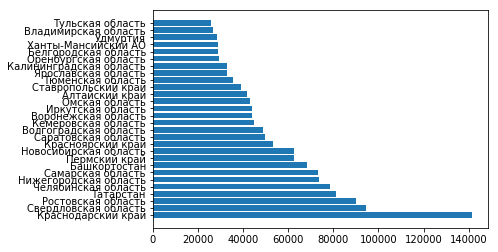

In [8]:
#Regios e seus numeros de anúncios
region_ads_number= df_train['region'].value_counts()
#Guardar os nomes das regiões
regions_names = np.array(region_ads_number.index)
#Guardar os números de anuncios por região.
ads_numbers= np.array(region_ads_number)
#Criar um dataframe com as informações anterios
df_region_ads = pd.DataFrame({'region': regions_names, 'number of ads': ads_numbers})
rank = np.arange(0, len(df_region_ads))
plt.barh(rank, df_region_ads['number of ads'])
plt.yticks(rank, df_region_ads['region'])
plt.show()

In [9]:
#Qualidade alta
df_train_A=df_train.query("deal_probability>=0.67") 
#Qualidade Media 
df_train_M=df_train.query("deal_probability>=0.33 and deal_probability<0.67") 
#Qualidade Baixa 
df_train_B=df_train.query("deal_probability<0.33") 

print('Qde de rows Qualidade alta.........:',len(df_train_A.index))
print('Qde de rows Qualidade Media........:',len(df_train_M.index))
print('Qde de rows Qualidade muito baixa..:', len(df_train_B.index))

number_of_ads=df_train.shape[0]
number_of_ads==len(df_train_A.index)+len(df_train_M.index)+len(df_train_B.index)

Qde de rows Qualidade alta.........: 164795
Qde de rows Qualidade Media........: 68478
Qde de rows Qualidade muito baixa..: 1270151


True

In [10]:
#df_test=pd.read_csv('test.csv.zip', compression='zip')
#print('Test Size=', len(df_test.index))
#df_test.head(1)

In [11]:
#sample_submission
#df_sample_submission=pd.read_csv('sample_submission.csv')
#print('Sample submission Size=', len(df_sample_submission.index))
#df_sample_submission.head(2)

In [12]:
#len(df_sample_submission['deal_probability'].unique())

### Pre-tratamento

In [13]:
perc_A=len(df_train_A.index)/number_of_ads
perc_M=len(df_train_M.index)/number_of_ads
perc_B=len(df_train_B.index)/number_of_ads
print(perc_A, '-',perc_M,'-', perc_B)

0.10961312311097868 - 0.04554802903239539 - 0.844838847856626


Extraction of 40.000 rows for trains and 20000 for tests

In [14]:
train_sample_size=40000
test_sample_size=20000
A_sample_size=int(perc_A*train_sample_size)
M_sample_size=int(perc_M*train_sample_size)
B_sample_size=train_sample_size-(A_sample_size+M_sample_size)
print('A size:', A_sample_size, '- M size: ', M_sample_size, '- B size : ',B_sample_size)

A size: 4384 - M size:  1821 - B size :  33795


In [15]:
import random

df_A=df_train_A.sample(n=A_sample_size, random_state=random.randint(1,A_sample_size))
df_M=df_train_M.sample(n=M_sample_size, random_state=random.randint(1,M_sample_size))
df_B=df_train_B.sample(n=B_sample_size, random_state=random.randint(1,B_sample_size))

df_test_sample=df_test.sample(n=test_sample_size, random_state=random.randint(1,test_sample_size))
print('A: ', df_A.shape, 'B: ', df_M.shape,' C:', df_B.shape,' test:', df_test_sample.shape)

A:  (4384, 18) B:  (1821, 18)  C: (33795, 18)  test: (20000, 18)


In [16]:
def getCorpus(row):
    desc=str(row['description'])
    tit=str(row['title'])
    #return str(desc.join(' ').join(tit))
    return desc+' '+tit

In [17]:
#df_A_=df_A[['description']].fillna('')
#df_M_=df_M[['description']].fillna('')
#df_B_=df_B[['description']].fillna('')
#df_test_sample_=df_test_sample[['description']].fillna('')

df_A_=df_A.fillna('')
df_M_=df_M.fillna('')
df_B_=df_B.fillna('')
df_test_sample_=df_test_sample.fillna('')


df_A_['corpus']=df_A_.apply(getCorpus, axis=1)
df_M_['corpus']=df_M_.apply(getCorpus, axis=1)
df_B_['corpus']=df_B_.apply(getCorpus, axis=1)
df_test_sample_['corpus']=df_test_sample_.apply(getCorpus, axis=1)

Para testes

In [18]:
df=df_A_[['description','title','corpus']].head(1)
#print('A: ', len(df['title']), 'B: ', len(df['description']),' C:', len(df['corpus']))
df['title']
df

,description,title,corpus
409615,"Чемодан для путешествий , все замки целые , вс...",Сумка дорожная,"Чемодан для путешествий , все замки целые , вс..."


In [19]:
list(df['description'].values)[0]

'Чемодан для путешествий , все замки целые , все работает, удобный и не большой по габаритам , можно не сдавать в багаж, идеально помещается на полке внутри самолета !! Куплен в штатах.'

In [20]:
list(df['corpus'].values)[0]

'Чемодан для путешествий , все замки целые , все работает, удобный и не большой по габаритам , можно не сдавать в багаж, идеально помещается на полке внутри самолета !! Куплен в штатах. Сумка дорожная'

In [21]:
list(df['title'].values)[0]

'Сумка дорожная'

In [22]:
#Remover pontuações nltk.tokenize

In [23]:
#converter para minusculo

Vamos nessa primeira análise considerar apenas as probalidade entre 0.33 e 0.66.
Preenchemos com espaço as descrições sem valores dos anúncios dessas probabilidades.

In [24]:
df_train_sample_=pd.concat([df_A_, df_M_, df_B_], axis=0)
#df_test_sample_
print('sample size and test size :', df_train_sample_.shape, df_test_sample_.shape)

sample size and test size : (40000, 19) (20000, 19)


In [25]:
df_trte_sample=pd.concat([df_train_sample_, df_test_sample_], axis=0)
df_trte_sample.shape

(60000, 19)

In [26]:
#Extract the corpus
#train_corpus=list(df_train_sample_['corpus'].values)
#test_corpus=list(df_test_sample_['corpus'].values)
#print('sample and test lengths:', len(train_corpus), len(test_corpus))

In [27]:
#Extract the corpus
corpus=list(df_trte_sample['corpus'].values)
print('Corpus length:', len(corpus))

Corpus length: 60000


In [28]:
#Remove pontuaction
#lowercase

### Features extraction
Only text on description column

Using SnowballStemmer

In [30]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\lfkop\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

In [31]:
from nltk.stem.snowball import SnowballStemmer

stemmer = SnowballStemmer("russian", ignore_stopwords=True)

#Criamos uma subclasse de CountVectorizer, que usará o snowballstemmer
class StemmedCountVectorizer(CountVectorizer):
    def build_analyzer(self):
        analyzer = super(StemmedCountVectorizer, self).build_analyzer()
        return lambda doc: ([stemmer.stem(w) for w in analyzer(doc)])

* Instanciar e configuramos o vectorizer com stop words russos. Os mesmos serão desconsiderados na construção dos tokens.
* Construimos os tokens, que são as features

In [32]:
stemmed_vectorizer = StemmedCountVectorizer(stop_words=stopwords.words('russian'))

#Extrair um array de descriptions tratadas acima
#corpus=list(df_train_M_['description'].values)

#Transformar usando a classe stemmed_vectorizer
X_vect = stemmed_vectorizer.fit_transform(corpus)
#X_test_vect = stemmed_vectorizer.fit_transform(test_corpus)
X_vect.shape

(60000, 60375)

In [33]:
#Transformar de novo para obter as features
tfidf_transformer = TfidfTransformer()
X_tfidf = tfidf_transformer.fit_transform(X_vect)

In [34]:
#features
X=X_tfidf
#Targets
y=df_trte_sample['deal_probability'].values 

print(X.shape)
print(y.shape)

(60000, 60375)
(60000,)


Extraimos parte das features e target para o treinamento. E outra parte para os testes

In [35]:
n=train_sample_size #n=32
#features and targets for trains
X_train=X[:n]
y_train=y[:n]
#features and targets for tests
X_test=X[n:]
y_test=y[n:]

### Previsão usando regressão com SVR

In [ ]:
clf=None
clf = SVR()
clf.fit(X_train, y_train)

In [ ]:
y_hat=clf.predict(X_test)

In [ ]:
print('Predicted :', y_hat)
print('Expected  :', y_test)

Vamos calcular o erro da previsão com variancia e desvio padrão.

In [ ]:
#Calcular a variancia de qualquer probalidade estimada
def setVariance(row):
    """
    Entrada:
        row:tupla de dataframe
    Saída:
        variancia:float
    """
    return (row['predicted_deal_probality']-row['expected_deal_probality'])**2

* Criar dataframe com as demandas/probabilidades previstas e as estimadas pelo classificador
* Aplicar a função em cada tupla para obter a variancia da probabilidade estimada.

In [ ]:
df_proba = pd.DataFrame({'expected_deal_probality': y_test,
                         'predicted_deal_probality': y_hat})
#Cria-se uma nova coluna no df
df_proba['variance'] = df_proba.apply(setVariance, axis=1)
df_proba.head()

Determinando o desvio padrão

In [ ]:
np.sqrt(df_proba[['variance']].sum()/len(df_proba.index))

Vamos calcular a variancia e desvio padrão considerando a media da amostra.

In [ ]:
mean=np.mean(y_test)
mean

In [ ]:
def setVariance2(row):
    return (row['predicted_deal_probality']-0.43571)**2

df_proba['variance'] = df_proba.apply(setVariance2, axis=1)
df_proba.head(10)

In [ ]:
#Devio padrão
desvio=np.sqrt(df_proba[['variance']].sum()/len(df_proba.index))
print("desvio", desvio)

### Previsão usando Regressão Linear

In [ ]:
from sklearn.linear_model import LinearRegression

In [ ]:
rg_predictor=None
rg_predictor= LinearRegression()
rg_predictor.fit(X_train, y_train)

In [ ]:
y_hat=rg_predictor.predict(X_test)

In [ ]:
print(y_hat[:5])
print(y_test[:5])

### Previsão usando classificação com Multinomial Naive Bayes
> Naive Bayes classifier for multinomial models
> The multinomial Naive Bayes classifier is suitable for classification with discrete features (e.g., word counts for text classification). The multinomial distribution normally requires integer feature counts. However, in practice, fractional counts such as tf-idf may also work.

Como os targets são valores continuos é necessário codifica-los para valores discretos, pois a classificação não viável para valores continuos. Senão um erro ocorre no classificador SVC.

Primeiro, verificamos que o array y_test contem realmente valores contínuos, que são ideais para a regressão. 

In [ ]:
print(utils.multiclass.type_of_target(y_test))

In [ ]:
#Instanciando o codificador
lab_enc = preprocessing.LabelEncoder()
#Encoded armazena valores discretos
y_train_encoded = lab_enc.fit_transform(y_train)
y_train_encoded

Testando que a conevrsão discretizou os targets em valores multiclasses

In [ ]:
print(utils.multiclass.type_of_target(y_train_encoded))

In [ ]:
#Instanciar e treinar
clf=None
clf = MultinomialNB()
clf.fit(X_train, y_train_encoded)

In [ ]:
#predizer
y_hat_encoded=clf.predict(X_test)
print(y_hat_encoded)

In [ ]:
#Converter e encontrar as probabilidades
y_hat=lab_enc.inverse_transform(y_hat_encoded)
print(y_hat[:5])
print(y_test[:5])

### Previsão usando classificação: SVC

> Novamente como trata-se de uma classificação onde os targets são valores continuos é necessário codifica-los para valores discretoss, senão um erro ocorre no classificador SVC. Usamos os variaveis definida acima no caso mnb.

Instanciando e treinando o classificador. Alteramos o kernel para 'linear', pois o valor default ('rbf') nem sempre realiza bem a classificação

In [ ]:
svc=None
svc = SVC(kernel='linear')
svc.fit(X_train,y_train_encoded)

In [ ]:
y_predicted=svc.predict(X_test)

In [ ]:
y_hat_encoded=lab_enc.inverse_transform(y_hat_encoded)
print(y_hat[:5])
print(y_test[:5])